<a href="https://colab.research.google.com/github/mschoi12/CT_segmentation_sample_code/blob/main/Bonemeta_Segmentation_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Module import

In [19]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from glob import glob
from tqdm import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from PIL import Image

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Cropping2D, concatenate

In [20]:
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

## Data Paths : images, labels

In [21]:
image_dir = '/content/drive/MyDrive/Dataset/sample_data/image/'
label_dir = '/content/drive/MyDrive/Dataset/sample_data/label/'

In [22]:
image_paths = []
for dirname, _, filenames in os.walk(image_dir):
    for filename in filenames:
        image_path = os.path.join(dirname, filename)
        image_paths.append(image_path)
print('number of total images :', len(image_paths))

number of total images : 255


In [23]:
label_paths = []
for dirname, _, filenames in os.walk(label_dir):
    for filename in filenames:
        label_path = os.path.join(dirname, filename)
        label_paths.append(label_path)
print('number of total labels :', len(label_paths))

number of total labels : 255


## Data split : train, val sets

In [24]:
def load_data(path,test_size=0.2):
    
    train_x, valid_x = train_test_split(image_paths, test_size=test_size, random_state=42)
    train_y, valid_y = train_test_split(label_paths, test_size=test_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [25]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(image_paths)
print(f"Dataset: Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

Dataset: Train: 163 - Valid: 51 - Test: 41


## Data preparation

In [26]:
H = 256
W = 256

shape = (256, 256, 1)
num_classes = 2
lr = 1e-4
batch_size = 8
epochs = 5

In [27]:
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x


def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x - 1
    x = x.astype(np.int32)
    return x


def tf_parse(x, y):
    def _parse(x, y):
        x = x.decode()
        y = y.decode()
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.int32])
    y = tf.one_hot(y, 3, dtype=tf.int32)
    x.set_shape([H, W, 3])
    y.set_shape([H, W,3])
    return x, y


# In[8]:


def tf_dataset(X, Y, batch):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

In [28]:
train_dataset = tf_dataset(train_x, train_y, batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size)

train_steps = len(train_x)//batch_size
valid_steps = len(valid_x)//batch_size
(train_steps, valid_steps)

(20, 6)

## Model Building

In [29]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import VGG19

In [30]:
def build_unet(shape, num_classes):
    inputs = Input(shape)

    """ Encoder """

    # 1
    cont1_1 = Conv2D(64, 3, padding='same',
                     activation='relu', kernel_initializer='he_normal', name='cont1_1')(inputs)  # 570, 570, 64
    cont1_2 = Conv2D(64, 3, padding='same',
                     activation='relu', kernel_initializer='he_normal', name='cont1_2')(cont1_1)  # 568, 568, 64

    # 2
    cont2_dwn = MaxPooling2D((2, 2), strides=2, name='cont2_dwn')(cont1_2)  # down-sampling; 284, 284, 64; 124
    cont2_1 = Conv2D(128, 3, padding='same',
                     activation='relu', kernel_initializer='he_normal', name='cont2_1')(cont2_dwn)  # 282, 282, 128
    cont2_2 = Conv2D(128, 3, padding='same',
                     activation='relu', kernel_initializer='he_normal', name='cont2_2')(cont2_1)  # 280, 280, 128

    # 3
    cont3_dwn = MaxPooling2D((2, 2), strides=2, name='cont3_dwn')(cont2_2)  # down-sampling; 140, 140, 128; 60
    cont3_1 = Conv2D(256, 3, padding='same',
                     activation='relu', kernel_initializer='he_normal', name='cont3_1')(cont3_dwn)  # 138, 138, 256
    cont3_2 = Conv2D(256, 3, padding='same',
                     activation='relu', kernel_initializer='he_normal', name='cont3_2')(cont3_1)  # 136, 136, 256

    """ Bridge """
    cont4_dwn = MaxPooling2D((2, 2), strides=2, name='cont4_dwn')(cont3_2)
    cont4_1 = Conv2D(512, 3, padding='same',
                     activation='relu', kernel_initializer='he_normal', name='cont4_1')(cont4_dwn)  # 512
    cont4_2 = Conv2D(512, 3, padding='same',
                     activation='relu', kernel_initializer='he_normal', name='cont4_2')(cont4_1)  # 512
    expn4_up = Conv2DTranspose(256, 2, strides=2, padding='same',
                               activation='relu', kernel_initializer='he_normal', name='expn4_up')(cont4_2)  # 256

    """ Decoder """
    expn3_concat = concatenate([expn4_up, cont3_2], axis=-1, name='expn3_concat')  # 512
    expn3_1 = Conv2D(256, 3, padding='same',
                     activation='relu', kernel_initializer='he_normal', name='expn3_1')(expn3_concat)  # 256
    expn3_2 = Conv2D(256, 3, padding='same',
                     activation='relu', kernel_initializer='he_normal', name='expn3_2')(expn3_1)  # 256

    expn3_up = Conv2DTranspose(128, 2, strides=2, padding='same',
                               activation='relu', kernel_initializer='he_normal', name='expn3_up')(expn3_2)  # 128

    # 2
    expn2_concat = concatenate([expn3_up, cont2_2], axis=-1, name='expn2_concat')  # 256
    expn2_1 = Conv2D(128, 3, padding='same',
                     activation='relu', kernel_initializer='he_normal', name='expn2_1')(expn2_concat)  # 128
    expn2_2 = Conv2D(128, 3, padding='same',
                     activation='relu', kernel_initializer='he_normal', name='expn2_2')(expn2_1)  # 128

    expn2_up = Conv2DTranspose(64, 2, strides=2, padding='same',
                               activation='relu', kernel_initializer='he_normal', name='expn2_up')(expn2_2)  # 64

    # 1
    expn1_concat = concatenate([expn2_up, cont1_2], axis=-1, name='expn1_concat')
    expn1_1 = Conv2D(64, 3, padding='same',
                     activation='relu', kernel_initializer='he_normal', name='expn1_1')(expn1_concat)
    expn1_2 = Conv2D(64, 3, padding='same',
                     activation='relu', kernel_initializer='he_normal', name='expn1_2')(expn1_1)



    """ Output layer """

    output_tensor = Conv2D(3, 1, padding='same', activation='softmax', name='output_tensor')(expn1_2)
    return Model(inputs, output_tensor)

## Metrics

In [31]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)


# In[18]:


smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)


# In[19]:


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

from tensorflow.keras.metrics import MeanIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)

In [50]:
import shutil
#shutil.os.mkdir(image_dir + "result")

## Model setting

In [38]:
model = build_unet((256, 256, 3), 3)
metrics = [dice_coef, iou]
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(lr), metrics=metrics)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 cont1_1 (Conv2D)               (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 cont1_2 (Conv2D)               (None, 256, 256, 64  36928       ['cont1_1[0][0]']                
                                )                                                           

In [34]:
callbacks = [
        ModelCheckpoint("model.h5", verbose=1, save_best_model=True),
        ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
        EarlyStopping(monitor="val_loss", patience=5, verbose=1)
    ]

## Training

In [41]:
history = model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=valid_dataset, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks)

Epoch 1/5
20/20 [==============================] - ETA: 0s - loss: 1.7712e-06 - dice_coef: 1.9073e-21 - iou: 1.9073e-21
Epoch 1: saving model to model.h5
20/20 [==============================] - 20s 976ms/step - loss: 1.7712e-06 - dice_coef: 1.9073e-21 - iou: 1.9073e-21 - val_loss: 1.7334e-06 - val_dice_coef: 1.9073e-21 - val_iou: 1.9073e-21 - lr: 1.0000e-05
Epoch 2/5
20/20 [==============================] - ETA: 0s - loss: 1.6639e-06 - dice_coef: 2.0663e-21 - iou: 2.0663e-21
Epoch 2: saving model to model.h5
20/20 [==============================] - 19s 976ms/step - loss: 1.6639e-06 - dice_coef: 2.0663e-21 - iou: 2.0663e-21 - val_loss: 1.6407e-06 - val_dice_coef: 1.9073e-21 - val_iou: 1.9073e-21 - lr: 1.0000e-05
Epoch 3/5
20/20 [==============================] - ETA: 0s - loss: 1.5793e-06 - dice_coef: 2.0663e-21 - iou: 2.0663e-21
Epoch 3: saving model to model.h5
20/20 [==============================] - 19s 957ms/step - loss: 1.5793e-06 - dice_coef: 2.0663e-21 - iou: 2.0663e-21 - val_l

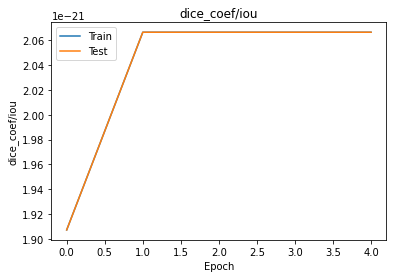

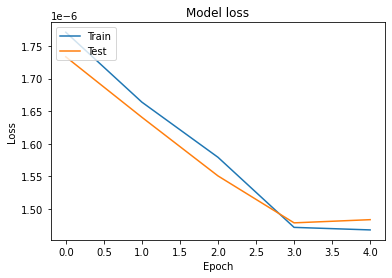

In [49]:
import matplotlib.pyplot as plt

# 6 훈련 과정 시각화 (정확도)
plt.plot(history.history['dice_coef'])
plt.plot(history.history['iou'])
plt.title('dice_coef/iou')
plt.xlabel('Epoch')
plt.ylabel('dice_coef/iou')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()